In [5]:
from surrogate_schema import Space

## First, authenticate to the API

All things Characteriazation, Sensitivity and Parametric analysis require that this Software Developement Kit (SDK) be authenticated to the API:

In [6]:
from surrogate_schema import APIClient

%load_ext dotenv
%dotenv

# typical block to authenticate to the API
client = APIClient(api_url="https://api.elementa.nyc")
client.whoami()  # shows that you are properly authenticated

The dotenv extension is already loaded. To reload it, use:
  %reload_ext dotenv


User(username='s.letellierduchesne', email='sam@cabonsignal.com', full_name='Samuel Letellier-Duchesne', disabled=None, valid_until=datetime.datetime(2025, 1, 29, 15, 28, 26))

Next, we list the possible weather files

# Create the design space

The design space is create below

In [7]:
{
        "WWR": 0.4,
        "WINU": 0.38,
        "WINSHGC": 0.4,
        "ROOFR": 35,
        "WALLR": 20,
        "INFIL": 0.07,
    }

{'WWR': 0.4,
 'WINU': 0.38,
 'WINSHGC': 0.4,
 'ROOFR': 35,
 'WALLR': 20,
 'INFIL': 0.07}

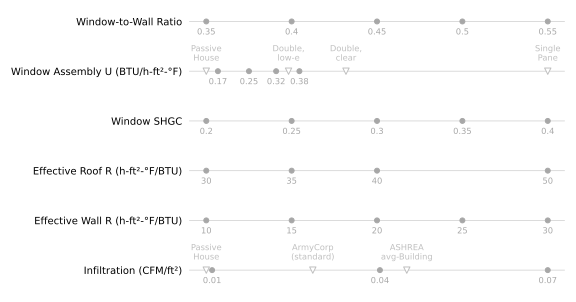

In [8]:
space = Space(
    categoricals=[
        dict(
            name="WWR",
            categories=(0.35, 0.4, 0.45, 0.5, 0.55),
        ),
        dict(
            name="WINU",
            categories=(0.17, 0.25, 0.32, 0.38),
        ),
        dict(
            name="WINSHGC",
            categories=(0.2, 0.25, 0.3, 0.35, 0.4),
        ),
        dict(
            name="ROOFR",
            categories=(30, 35, 40, 50),
        ),
        dict(
            name="WALLR",
            categories=(10, 15, 20, 25, 30),
        ),
        dict(
            name="INFIL",
            categories=(0.01, 0.04, 0.07),
        ),
    ]
)

space

In [9]:
from surrogate_schema.space.design_space import SupportedParameter

In [10]:
type(SupportedParameter)

enum.EnumMeta

In [11]:
SupportedParameter["INFIL"]

<SupportedParameter.INFIL: 'INFIL'>

In [12]:
list(SupportedParameter)

[<SupportedParameter.INFIL: 'INFIL'>,
 <SupportedParameter.FORMFACT: 'FORMFACT'>,
 <SupportedParameter.DELTA_FANPOWER: 'DELTA_FANPOWER'>,
 <SupportedParameter.FANPOWER: 'FANPOWER'>,
 <SupportedParameter.PUMPHEAD: 'PUMPHEAD'>,
 <SupportedParameter.SATRESET: 'SATRESET'>,
 <SupportedParameter.HUMIDMAX: 'HUMIDMAX'>,
 <SupportedParameter.VENTSCH: 'VENTSCH'>,
 <SupportedParameter.ACH: 'ACH'>,
 <SupportedParameter.HRV: 'HRV'>,
 <SupportedParameter.LPDSCH: 'LPDSCH'>,
 <SupportedParameter.EPDSCH: 'EPDSCH'>,
 <SupportedParameter.LPD: 'LPD'>,
 <SupportedParameter.EPD: 'EPD'>,
 <SupportedParameter.ROOFR: 'ROOFR'>,
 <SupportedParameter.WALLR: 'WALLR'>,
 <SupportedParameter.WINSHGC: 'WINSHGC'>,
 <SupportedParameter.WINU: 'WINU'>,
 <SupportedParameter.WWR: 'WWR'>,
 <SupportedParameter.WWRN: 'WWRN'>,
 <SupportedParameter.WWRE: 'WWRE'>,
 <SupportedParameter.WWRS: 'WWRS'>,
 <SupportedParameter.WWRW: 'WWRW'>,
 <SupportedParameter.WINUN: 'WINUN'>,
 <SupportedParameter.WINUE: 'WINUE'>,
 <SupportedParameter

## Batch Simulation

### Prepare the seed model for the API

Model must be in "world" coordinates. There is a function for that!

In [13]:
from archetypal import IDF

idf = IDF("HVAC.idf", iddname="Energy+.idd")

In [14]:
idf.to_world()

Model already set as World coordinates


In [15]:
%matplotlib notebook

In [16]:
idf.view_model()

<IPython.core.display.Javascript object>

(<Figure size 640x480 with 1 Axes>, [<Axes3D: >])

In [17]:
idf.saveas("HVAC.idf")

<IDF object HVAC.idf
at HVAC.idf
	Version 9.6.0
Simulation Info:
	Not yet simulated>

Optionally, we can also simulate the model *locally* (as oppsosed to AWS) to make sure the model runs. Passing the option `design_day=True` to the `simulate` command will ensure that we are not running the whole year of simulation but just the design days. It is just faster.

In [18]:
idf.simulate(
    epw="CAN_ON_Toronto.716240_CWEC.epw",
    design_day=True,
)

/Applications/EnergyPlus-9-6-0/ExpandObjects #0-HVAC.idf: 0.00it [00:00, ?it/s]

/Applications/EnergyPlus-9-6-0/energyplus HVAC.idf: 0it [00:00, ?it/s]

<IDF object HVAC.idf
at HVAC.idf
	Version 9.6.0
Simulation Info:
	Not yet simulated>

Energyplus produces a lot of files for our simulation. To keep things tidy and not to fill up the jupyter hub with junk, we can call a linux command to delete the cache folder, where all simulation results reside:

In [19]:
!rm -rv cache

cache/203a3a295aba72501d82ccd97466b060
cache


## Create Job and Submit

Next, we create a BuildingAnalysis object which contains our design space, baseline and defines other parameters for the simulation.

In [20]:
from surrogate_schema import BuildingAnalysis

analysis_1 = BuildingAnalysis(
    company="Brampton",
    project="Brampton",
    local_epw="CAN_ON_Toronto.716240_CWEC.epw",
    local_seed_model="HVAC.idf",
    local_iddname="Energy+.idd",  # IDD file is used in AWS to read/parse the idf model
    design_space=space,
    baseline={
        "WWR": 0.4,
        "WINU": 0.38,
        "WINSHGC": 0.4,
        "ROOFR": 35,
        "WALLR": 20,
        "INFIL": 0.07,
    },
    analysis_id='ea3c4f33-174b-4427-90c1-bc2675d2cd05'
)

ValidationError: 1 validation error for BuildingAnalysis
local_iddname
  String should match pattern '^.*\.(ddy)$' [type=string_pattern_mismatch, input_value='Energy+.idd', input_type=str]
    For further information visit https://errors.pydantic.dev/2.6/v/string_pattern_mismatch

In [ ]:
analysis_1

### Determining the samples or runs to simulate

In this particular project, we are only interested in runnning the sensitivity runs. Therefore, we are going to assing result of the `create_sensitivity_space` method to the `BuildingAnalysis.sampled_space` attribute.

Our Sampeld space looks like this:

In [ ]:
analysis_1.sampled_space = analysis_1.create_space()

In [ ]:
%matplotlib inline

In [ ]:
analysis_1.sampled_space.pretty_bubble_chart()

In [ ]:
analysis_1.sampled_space.to_df().hist()

### Preparing the job

Based on the above, prapering the job creates all the required information needed to submit a job to AWS Bacth. First, your EPW file and your seed model are going to be uploaded to AWS S3. Then a parameter file very similar to the `sampled_space.to_df()` table above is also uploaded.

In [ ]:
analysis_1.prepare_job()

In [ ]:
analysis_1.job.containerOverrides.resourceRequirements[0].value = "4048"

In [ ]:
analysis_1.job

### Sumitting the job

Next we can submit the job to AWS. Below, the command returns a `SubmitJobResponse` with some information on the job:

In [ ]:
analysis_1.submit_job()

### Tracking the job status

You can track the job status by calling the `track_status` method. This function will *run* in the notebook until all jobs are **COMPLETED** or **FAILED**.

If you wish to relieve the notebook to continue working while AWS does its thing, you can interrupt the kernel (⬛) and you will be asked if you wish to terminate the job of not. By the way, after a job has been submitted, you can terminate the job by calling `BuildingAnalysis.terminate_job()` method.

In [ ]:
analysis_1.track_status()

## What if some or all runs are failing?

If runs are failing, you can call the `BuildingAnalysis.get_job_logs(0)` method and specify a run number, starting at 0. For instance, if the first run failed, we call `analysis_1.explain(0)`

By default, the fucntion gets 100 lines of logs. You can specify with `startFromHead=True` or `False` if you want the last lines or the first lines (end of simulation or beginning of simulation).

In [ ]:
logs = analysis_1.get_job_logs(1, limit=10, startFromHead=False)

Another way of getting some information about a tricky job is to call the `describe_submitted_job` method with a run number. The dictionary method will display things nicely in the results. Look for keywords such as **status** and **statusReason**:

In [ ]:
analysis_1.describe_submitted_job(0).dict()

### Saving and reloading an analysis

So far, the analysis_1 object has been livnig in *memory*. It is good practice to serialise (write) the object in order to be able to reload it in the future. This is especially usefull if the server quits and needs to be launched again. Or if you want to share an anlysis with a colleague!

In [ ]:
analysis_1.save("analysis_1.json")

To reload an analysis:

In [ ]:
from surrogate_schema import BuildingAnalysis

analysis_1 = BuildingAnalysis.parse_file("analysis_1.json")

# Sensitivity Analysis

## Retrieving results

After an analysis has completed, runs that have succeeded (often all of them) can be retreived with the `get_sensitivity_results` method. If some of the runs have failed - maybe some parameter don't make sense and make EnergyPlus crash - they will simply not appear in the DataFrame.

An Important step here is to determine the cooling COP and the heating COP of the system to calculate accurately the EUI, TEDI and CEDI metrics. This can be determined in the Characterization analyis. For now, we will assume the following:

In [ ]:
df = analysis_1.get_sensitivity_results(COOLCOP=5, HEATCOP=5)
df.to_csv("sensitivity.csv")

### Saving as a csv file

To save the file to a csv, like with any pandas.DataFrame objects, simply call the `to_csv` method and pass a filename.

In [ ]:
df.to_csv("sensitivity.csv")

### Getting the parametric results

In [ ]:
df = analysis_1.get_parametric_results(COOLCOP=4.5, HEATCOP=4.5)
df.to_csv("parametric.csv")

It can be plotted:

### Plotting the Sensitivity results

Below is the code to generate an *interactive* plot (you can pick the metric to view) which will eventually be included in the SDK.

In [ ]:
METRICS = [
    "EUI_kBtu_per_sqft",
    "TEDI_kBtu_per_sqft",
    "CEDI_kBtu_per_sqft",
    "EDI_kBtu_per_sqft",
]

nb_vars = df.Variable.unique().size


def plot_func(metric):
    import matplotlib.pyplot as plt

    fig, axes = plt.subplots(
        nrows=nb_vars // 3 or 1, ncols=min(nb_vars, 3), sharey=True, figsize=(15, 10)
    )
    axes = axes.ravel()
    ylim = (df[metric].values.min(), df[metric].values.max())
    for i, (var, data) in enumerate(df.groupby("Variable")):
        data.drop_duplicates(inplace=True)
        if "WINU" in var:
            data[var] = 1 / data[var]
        # plot the lineplot first
        ax = data.plot(
            x=var,  # plot var a x axis
            y=metric,  # plot metric a y axis
            color="#1f77b4",
            label=var,
            ax=axes[i],
        )
        if "WINU" in var:
            ax.set_xticks(data[var], labels=1 / data[var])
        else:
            ax.set_xticks(data[var])
        # List of colors c for markers
        c = (
            data[[var, "Baseline"]]
            .set_index("Baseline")
            .apply(lambda x: "#b4d6e8" if x.name == "no" else "#1f77b4", axis=1)
            .tolist()
        )
        # Plot markers with scatter plot, second
        data.plot.scatter(
            x=var,
            y=metric,
            c=c,
            marker="o",
            s=50,
            edgecolors="#1f77b4",
            ax=axes[i],
        )
        # Plot the horizontal line of the baseline
        for h in data.loc[data["Baseline"] == "yes", metric]:
            ax.axhline(h, c="#eaeaea", zorder=-1)
        ax.set_ylabel(metric)  # set ylabel

In [ ]:
%matplotlib inline

from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

interact(
    plot_func,
    metric=widgets.Dropdown(
        options=METRICS,
        index=0,
    ),
)

In [ ]:
analysis_1.

## Other API Hacks

A couple interesting calls that can be made to the API using python commmands are detailed bellow: By the way, all the API entrypoints are detailed at [https://api.elementa.nyc/docs](https://api.elementa.nyc/docs).

### Downloading one of the simulation files

If you want to download the idf file generated for one of the runs, we can use the `/downloadfile/` entrypoint with a "GET" method. We need to provide the URL of the file. We can get that URL from the analysis Job attribute:

In [ ]:
analysis_1.job.parameters.idf_output_dir

By default, the generated idf model is saved in a *folder* called "/idfs", under the analysis id. In addition, the model filename always has the following form: `in_<run_numer>.idf`. Therefore, we can construct a URL and pass it as a parameter of the API. FYI, the [API documentations](https://api.elementa.nyc/docs#/default/download_file_downloadfile__get) tells us that the get method needs a `parameter` named `s3_file_path`. This is what we put below:

In [ ]:
request = analysis_1.Client.client.get(
    f"/downloadfile/",
    params={"s3_file_path": f"{analysis_1.job.parameters.idf_output_dir}in_0.idf"},
)

# save the downloaded content to a file named `in_0.idf`
with open("in_0.idf", "wb") as f:
    f.write(request.content)

In [ ]:
idf_aws = IDF("in_0.idf")

In [ ]:
idf_aws.view_model()

We can then write a function that calculates the total envelope area (roofs and walls) to be able to calculate the Heat_Loss_Form_Factor of the building:

In [ ]:
def total_envelope_area(self):
    """Get the total gross envelope area including windows [m2].

    Note:
        The envelope is consisted of surfaces that have an outside boundary
        condition different then `Adiabatic` or `Surface` or that participate in
        the heat exchange with the exterior.

    """
    total_area = 0
    area = 0
    zones = self.idfobjects["ZONE"]
    zone: EpBunch
    for zone in zones:
        for surface in zone.zonesurfaces:
            if hasattr(surface, "tilt"):
                if surface.tilt == 180.0:
                    multiplier = float(
                        zone.Multiplier if zone.Multiplier != "" else 1
                    )

                    area += surface.area * multiplier
    self._area_total = area
    for surface in self.getsurfaces():
        if surface.Outside_Boundary_Condition.lower() in ["adiabatic", "surface"]:
            continue
        zone = surface.get_referenced_object("Zone_Name")
        multiplier = float(
            zone.Multiplier if zone.Multiplier != "" else 1
        )
        total_area += surface.area * multiplier
    return total_area

In [ ]:
IDF.total_envelope_area = total_envelope_area  # assign the function to the class itself.

Note that the `total_building_area` is a property and not a function, that is why it is not called with parentheses:

In [ ]:
heat_loss_form_factor = idf.total_envelope_area() / idf.total_building_area
heat_loss_form_factor